# **How Data Augmentation using Back-Translation Affects the Text Classification Performance**

Student Name: Chandreen Ravihari Liyanage

Student ID: 1158931

***Main aim***

Description about the project: The primary objective of this project is to assess the impact of augmenting data using the "backtranslation" technique on the performance of text classification tasks. Backtranslation involves converting the original text from one language (in this case, English) into another language (in this case, French), and then translating it back into the original language. This technique proposes that during this transformation, the original text will be regenerated in a different manner, thereby producing augmented text that can be utilized effectively.

***The method***

Therefore, in this study, I employed the backtranslation technique to address the imbalance in the dataset. Initially, the dataset comprised the following records: (0-159, 1-219, 2-109). After applying backtranslation, the dataset was rebalanced to (0 - 219, 1 - 219, 2 - 218). Subsequently, I separately fine-tuned the BERT model (bert-base-uncased) on both the original and augmented datasets. The performance was evaluated using a separate dataset that had not undergone augmentation.

***Hyper-parameters***

The hyper-parameter setup used in this evaluation is , epochs = 10, batch size=16, learning rate = 2e-5, optimizer= Adam, and epsilon=1e-8.

***Dataset***

The Twitter dataset used in this study pertains to abortion stance classification and comprises three classes: 0-against, 1-favor, and 2-none, considering the stance target of "legalization of abortion." This dataset was sourced from "https://paperswithcode.com/dataset/tweeteval".

***Preprocessing ***

I conducted text preprocessing in two stages: 1) prior to data augmentation, and 2) before classification. During the first stage, I employed simple techniques such as removing #, @user mentions, URLs, extra spaces, line breaks, and punctuations. This approach aimed to maintain the augmented data's similarity to the original text. In contrast, for the second stage of preprocessing, I implemented more advanced techniques including stopword removal, stemming, and lemmatization.

**Conclusion**

The results indicate a reduction in testing accuracy from 62% to 35% with the presence of the augmented dataset. Additionally, the backtranslation technique has resulted in the generation of numerous duplicated records. Duplicate records with consistent labels essentially offer redundant information, as they fail to contribute any novel insights to the model. In fact, incorporating duplicate records may introduce bias, as the model could overly depend on this duplicated data and overestimate the significance of certain patterns, potentially leading to overfitting. However, it's noteworthy that overfitting was not observed in the results.

In [ ]:
!pip install transformers
!pip install sentencepiece


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 59.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 68.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.0 MB/s eta 0:00:00


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler,random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import transformers
from transformers import BertForSequenceClassification, AdamW, BertConfig,BertTokenizer,get_linear_schedule_with_warmup

In [ ]:
import random
import time
import datetime
import gc

In [ ]:
import pandas as pd
import json
import csv
import numpy as np

import os
import time
import re

In [ ]:
from transformers import MarianMTModel, MarianTokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Setting the base path
base_path =  "/content/gdrive/MyDrive/Lakehead//NLP_Class/Project"

In [ ]:
os.chdir(base_path)

In [ ]:
df = pd.read_csv("TweetEval.csv")
df

,Unnamed: 0,text,label,label_text
0,0,we remind ourselves that love means to be will...,1,against
1,1,@user @user and most Islanders have different ...,0,none
2,2,"Life is #precious & so are babies, mothers, & ...",1,against
3,3,@user too many people are taking this to serio...,0,none
4,4,Dude i won a #freeshirt from @user ! I never w...,0,none
...,...,...,...,...
482,578,Oh look!!! So not only are antichoice strongly...,2,favor
483,579,@user I don't think I have a right to use some...,2,favor
484,581,People aren't 'pro-life' they're 'pro-birth'. ...,2,favor
485,582,"@user i don't follow the news, is there a new ...",0,none


In [ ]:
# I kept a seperate dataset to evaluate the classification performance before and after data augmentation
df_test = pd.read_csv("TweetEval_testdata.csv")
df_test

,Unnamed: 0,text,label,label_text
0,0,Need a ProLife R.E. Agent? - Support a ProLife...,1,against
1,1,Where is the childcare program @user which you...,1,against
2,2,I get several requests with petitions to save ...,1,against
3,3,"we must always see others as Christ sees us,we...",1,against
4,4,PRAYERS FOR BABIES Urgent prayer one in Lexing...,1,against
...,...,...,...,...
176,336,Every time you respond to something that frust...,0,none
177,337,Obamcare loses again in the Supreme Court. Rel...,0,none
178,342,BRAVO TO BOTH OF YOU BEAUTIFULLY EXPLAINED HOL...,2,favor
179,344,"My body, my life. You fuck it up in a way I'm ...",2,favor


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Recording class counts

In [ ]:
df['label'].value_counts()

1    219
0    159
2    109
Name: label, dtype: int64

In [ ]:
class_counts = df['label'].value_counts().reset_index()
class_counts.columns = ["class", "count"]
class_counts

,class,count
0,1,219
1,0,159
2,2,109


In [ ]:
c1=class_counts.loc[class_counts['class'] == 0, 'count']
c2=class_counts.loc[class_counts['class'] == 1, 'count']
c3=class_counts.loc[class_counts['class'] == 2, 'count']


c1=int(c1)
c2=int(c2)
c3=int(c3)


In [ ]:
df_test['label'].value_counts()

0    63
1    60
2    58
Name: label, dtype: int64

## Preprocessing

In [ ]:
# Perform some preprocessing relevant to Twitter text. I do not perform stemming, lemmatization as we need text
# more similar to the original text since we are performing data augmentation

def clean_text(text: str):
    text = text.lower() #change case to lower
    text = text.strip()  # Remove extra spaces
    text = text.replace("#", "")  # Remove hashtags
    text = text.replace("@user", "")  # Remove hashtags
    text = re.sub(r"http\S+", "", text)  # Removed urls
    text = re.sub(r"[^\w\s]", "", text)  # Removed punctuations #Sentence
    return text

In [ ]:
df["text"] = df.text.apply(lambda x: clean_text(x))


In [ ]:
df

,Unnamed: 0,text,label,label_text
0,0,we remind ourselves that love means to be will...,1,against
1,1,and most islanders have different definition...,0,none
2,2,life is precious so are babies mothers fathe...,1,against
3,3,too many people are taking this to seriously ...,0,none
4,4,dude i won a freeshirt from i never win anyt...,0,none
...,...,...,...,...
482,578,oh look so not only are antichoice strongly ag...,2,favor
483,579,i dont think i have a right to use someone el...,2,favor
484,581,people arent prolife theyre probirth when a mo...,2,favor
485,582,i dont follow the news is there a new law tha...,0,none


## Data Augmentation using Backtranslation

Using Backtranslating technique, I convert the selected English text into french and then convert it to English to use as augmented data.

the first model translating English to French

In [ ]:
# Get the name of the first model
first_model_name = 'Helsinki-NLP/opus-mt-en-fr'

# Get the tokenizer
first_model_tkn = MarianTokenizer.from_pretrained(first_model_name)

# Load the pretrained model based on the name
first_model = MarianMTModel.from_pretrained(first_model_name)

/usr/local/lib/python3.9/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


the second model translating French to English.

In [ ]:
# Get the name of the second model
second_model_name = 'Helsinki-NLP/opus-mt-fr-en'

# Get the tokenizer
second_model_tkn = MarianTokenizer.from_pretrained(second_model_name)

# Load the pretrained model based on the name
second_model = MarianMTModel.from_pretrained(second_model_name)

to properly implement the translation feature, we need to add the special token >>{tgt}<< in front of each text that needs to be translated. {tgt} is either fr or en.

In [ ]:
def format_batch_texts(language_code, batch_texts):

  formated_bach = ">>{}<< {}".format(language_code, batch_texts)

  return formated_bach

function responsible for the translation of the batch of texts

In [ ]:
def perform_translation(batch_texts, model, tokenizer, language="fr"):
    # Prepare the text data into appropriate format for the model
    formated_batch_texts = format_batch_texts(language, batch_texts)

    # Generate translation using model
    translated = model.generate(**tokenizer(formated_batch_texts, return_tensors="pt", padding=True))

    # Convert the generated tokens indices back into text
    translated_texts = tokenizer.decode(translated[0], skip_special_tokens=True)

    return translated_texts


In [ ]:
def perform_back_translation(batch_texts, original_language="en", temporary_language="fr"):

  # Translate from Original to Temporary Language
  tmp_translated_batch = perform_translation(batch_texts, first_model, first_model_tkn, temporary_language)

  # Translate Back to English
  back_translated_batch = perform_translation(tmp_translated_batch, second_model, second_model_tkn, original_language)

  return back_translated_batch

In [ ]:
# Declare global lists to store results

augmented_data =[]
augmented_data_labels =[]
original_data = []

In [ ]:
def appending_data(new_text, label, original):

  augmented_data.append(new_text)
  augmented_data_labels.append(label)
  original_data.append(original)

In [ ]:
# Call API to generate text

class_1=0
class_2=0
class_3=0

# Set the max records upto 219 as class 1 has this highest number of records
max_records=219
i=0

for index, row in df.iterrows():

  original_text = row['text']
  class_label = row['label']

  print(i)
  i+=1

  # calling the function to add a token to the text
  formated_text = format_batch_texts("fr", original_text)
  # print(formated_text)
  # print(formated_exp)
  # print("\n")


  if(class_label==0 and c1+class_1 < max_records):
    augmented_text = perform_back_translation(formated_text)
    appending_data(augmented_text, class_label, original_text)
    class_1+=1

  elif (class_label==1 and c2+class_2 < max_records):
    augmented_text = perform_back_translation(formated_text)
    appending_data(augmented_text, class_label, original_text)
    class_2+=1

  elif (class_label==2 and c3+class_3 < max_records):
    augmented_text = perform_back_translation(formated_text)
    appending_data(augmented_text, class_label, original_text)
    class_3+=1


0
1


/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (512) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

In [ ]:
New_dataset = pd.DataFrame({'original_text': original_data, 'new_text': augmented_data, 'label': augmented_data_labels})

In [ ]:
New_dataset

,original_text,new_text,label
0,and most islanders have different definition...,Most islanders have different definitions of r...,0
1,too many people are taking this to seriously ...,Too many people take this seriously.,0
2,dude i won a freeshirt from i never win anyt...,Dude I won a freeshirt from I never won anythi...,0
3,like yall can try and push your views on me an...,As Yall can try and push your views on me anyw...,0
4,just because it is legal doesnt make it god ho...,Just because it's legal doesn't make God the h...,0
...,...,...,...
164,complications come with all types of medical ...,· Complications come with all types of medical...,2
165,what doesnt reduce abortions making it illegal...,What does not reduce abortions makes it illega...,2
166,oh look so not only are antichoice strongly ag...,So look at not only the anti-choice is strongl...,2
167,i dont think i have a right to use someone el...,I don't think I have the right to use someone ...,2


In [ ]:
New_dataset['label'].value_counts()

2    109
0     60
Name: label, dtype: int64

In [ ]:
New_dataset.to_csv("augmented_data.csv", index=False)

In [ ]:
New_dataset = pd.read_csv("augmented_data.csv")

## Combine augmented data with original dataset

In [ ]:
# prepare original dataset and testing set
originaldata = df.drop(['Unnamed: 0', 'label_text'], axis=1)
originaldata

testdata = df_test.drop(['Unnamed: 0', 'label_text'], axis=1)
testdata

,text,label
0,Need a ProLife R.E. Agent? - Support a ProLife...,1
1,Where is the childcare program @user which you...,1
2,I get several requests with petitions to save ...,1
3,"we must always see others as Christ sees us,we...",1
4,PRAYERS FOR BABIES Urgent prayer one in Lexing...,1
...,...,...
176,Every time you respond to something that frust...,0
177,Obamcare loses again in the Supreme Court. Rel...,0
178,BRAVO TO BOTH OF YOU BEAUTIFULLY EXPLAINED HOL...,2
179,"My body, my life. You fuck it up in a way I'm ...",2


In [ ]:
# prepare augmented dataset
augmented = New_dataset.drop(['original_text'], axis=1)
augmented

,new_text,label
0,Most islanders have different definitions of r...,0
1,Too many people take this seriously.,0
2,Dude I won a freeshirt from I never won anythi...,0
3,As Yall can try and push your views on me anyw...,0
4,Just because it's legal doesn't make God the h...,0
...,...,...
164,· Complications come with all types of medical...,2
165,What does not reduce abortions makes it illega...,2
166,So look at not only the anti-choice is strongl...,2
167,I don't think I have the right to use someone ...,2


In [ ]:
frames = [originaldata, augmented.rename(columns={'new_text':'text'})]
final = pd.concat(frames, ignore_index=True)
final

,text,label
0,we remind ourselves that love means to be will...,1
1,and most islanders have different definition...,0
2,life is precious so are babies mothers fathe...,1
3,too many people are taking this to seriously ...,0
4,dude i won a freeshirt from i never win anyt...,0
...,...,...
651,· Complications come with all types of medical...,2
652,What does not reduce abortions makes it illega...,2
653,So look at not only the anti-choice is strongl...,2
654,I don't think I have the right to use someone ...,2


In [ ]:
final['label'].value_counts()

1    219
0    219
2    218
Name: label, dtype: int64

In [ ]:
final.to_csv("final_dataset.csv", index=False)

## Preprocessing data for classification

In addition to basic preprocessing, perform further preprocessing, such as stop word removal, stemming, lemmatization.

In [ ]:
# This is the function to map NTLK position tags - for lemmatizing
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [ ]:
# Use a tokenizer from the NLTK library

def preprocessing_stage2(text: str):

    text = text.lower() #change case to lower
    text = text.strip()  # Remove extra spaces
    text = text.replace("#", "")  # Remove hashtags
    text = text.replace("@user", "")  # Remove hashtags
    text = re.sub(r"http\S+", "", text)  # Removed urls
    text = re.sub(r"[^\w\s]", "", text)  # Removed punctuations #Sentence


    processed_sentence = []
    stemmed_sentence = []
    lemmatized_sentence = []


    # First stopword removal-------------------
    stopwords = ["that", "and", "is", "it", "a", "an", "the", "this",  "to"]

    # Tokenize the sentence
    words = word_tokenize(text)
    for w in words:
        if w not in stopwords:
            processed_sentence.append(w)
    text = " ".join(processed_sentence)


    #second stemming--------------------------------
    # Initialize the stemmer
    snow = SnowballStemmer('english')

    # Tokenize the sentence
    words = word_tokenize(text)
    for w in words:
        # Stem the word/token
        stemmed_sentence.append(snow.stem(w))
    stemmed_text = " ".join(stemmed_sentence)


    #thrid lemmatization---------------------------------------
    # Initialize the lemmatizer
    wl = WordNetLemmatizer()

    # Tokenize the sentence
    words = word_tokenize(stemmed_text)
    # Get position tags
    word_pos_tags = nltk.pos_tag(words)
    # Map the position tag and lemmatize the word or token
    for idx, tag in enumerate(word_pos_tags):
        lemmatized_sentence.append(wl.lemmatize(tag[0], get_wordnet_pos(tag[1])))

    lemmatized_text = " ".join(lemmatized_sentence)

    return lemmatized_text

In [ ]:
originaldata["text"] = originaldata.text.apply(lambda x: preprocessing_stage2(x))
final["text"] = final.text.apply(lambda x: preprocessing_stage2(x))
testdata["text"] = testdata.text.apply(lambda x: preprocessing_stage2(x))

In [ ]:
originaldata

,text,label
0,we remind ourselv love mean be will give until...,1
1,most island have differ definit of time access...,0
2,life precious so be babi mother father pleas s...,1
3,too mani peopl be take serious semst,0
4,dude i win freeshirt from i never win anyth lo...,0
...,...,...
482,oh look so not onli be antichoic strong agains...,2
483,i dont think i have right use someon el bodi w...,2
484,peopl arent prolif theyr probirth when mother ...,2
485,i dont follow news there new law all gay peopl...,0


In [ ]:
final

,text,label
0,we remind ourselv love mean be will give until...,1
1,most island have differ definit of time access...,0
2,life precious so be babi mother father pleas s...,1
3,too mani peopl be take serious semst,0
4,dude i win freeshirt from i never win anyth lo...,0
...,...,...
651,complic come with all type of medic procedur d...,2
652,what doe not reduc abort make illeg what make ...,2
653,so look at not onli antichoic strong against p...,2
654,i dont think i have right use someon el bodi w...,2


## Perform Classification

## **Original dataset**

In [ ]:
def to_list(dataset):
  labels = dataset['label'].tolist()
  texts = dataset['text'].tolist()

  print(pd.Series(labels).value_counts())

  return labels, texts


In [ ]:
label_list, texts = to_list(originaldata)

1    219
0    159
2    109
dtype: int64


In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
max_len = 0

# For every tweet.
for sent in texts:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  41


In [ ]:
input_ids = []
attention_masks = []

# For every tweet...
for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        truncation = True,
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(label_list)

# Print sentence 0, now as a list of IDs.
print('Original: ', texts[0])
print('Token IDs:', input_ids[0])


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  we remind ourselv love mean be will give until hurt mother teresa
Token IDs: tensor([  101,  2057, 10825, 14635,  2884,  2615,  2293,  2812,  2022,  2097,
         2507,  2127,  3480,  2388, 12409,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0])


In [ ]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 80-20 train-validation split.

train_size = int(0.8 * len(dataset))
val_size = len(dataset)  - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  389 training samples
   98 validation samples


In [ ]:
batch_size = 16

In [ ]:
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 3, # The number of output labels--3 for stance classification.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
epochs = 10

# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
total_steps

250

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []
t_acc=[]
t_loss=[]
v_acc=[]
v_loss=[]

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    #               Training
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0
    total_train_accuracy = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)
        # ------------------------------------------------------------ Added by me
        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_train_accuracy += flat_accuracy(logits, label_ids)
        # ------------------------------------------------------------

        loss = output.loss
        total_train_loss += loss.item()
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Report the final accuracy for this validation run.
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    print("  Train Accuracy: {0:.2f}".format(avg_train_accuracy))
    # ---------------------------------------------------

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))



    #               Validation
    # After the completion of each training epoch, measure our performance on
    # the validation set.
    print("")
    print("Running Validation...")
    t0 = time.time()

    model.eval()
    # Tracking variables
    total_eval_accuracy = 0
    best_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0


    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            output= model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()
        # Move logits and labels to CPU if we are using GPU
        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    if avg_val_accuracy > best_eval_accuracy:
        torch.save(model, 'bert_model1')
        best_eval_accuracy = avg_val_accuracy
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))


    # ----------------------------------------------------------
    t_acc.append(avg_train_accuracy)
    t_loss.append(avg_train_loss)
    v_acc.append(avg_val_accuracy)
    v_loss.append(avg_val_loss)
    #----------------------------------------------------------

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Accur': avg_train_accuracy,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...
  Train Accuracy: 0.44

  Average training loss: 1.06
  Training epcoh took: 0:00:06

Running Validation...
  Accuracy: 0.59
  Validation Loss: 0.94

======== Epoch 2 / 10 ========
Training...
  Train Accuracy: 0.64

  Average training loss: 0.91
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.61
  Validation Loss: 0.88

======== Epoch 3 / 10 ========
Training...
  Train Accuracy: 0.72

  Average training loss: 0.73
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.48
  Validation Loss: 1.12

======== Epoch 4 / 10 ========
Training...
  Train Accuracy: 0.78

  Average training loss: 0.61
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.61
  Validation Loss: 0.88

======== Epoch 5 / 10 ========
Training...
  Train Accuracy: 0.86

  Average training loss: 0.44
  Training epcoh took: 0:00:03

Running Validation...
  Accuracy: 0.68
  Validation Loss: 0.81

======== Epoch 6 / 10 ========
Tra

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

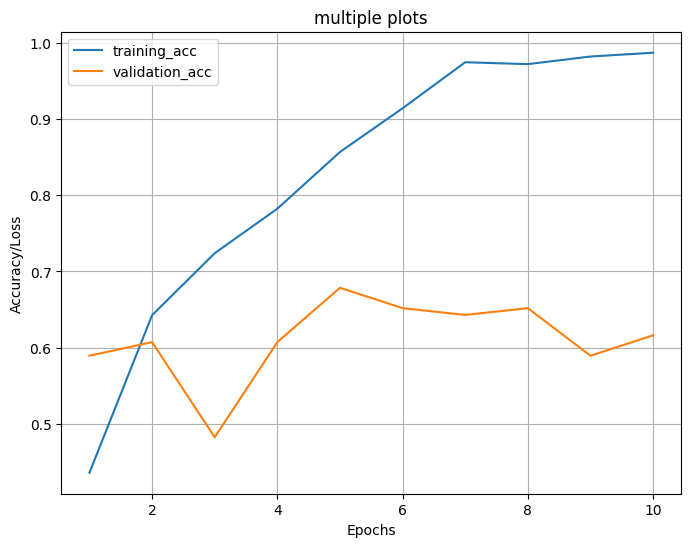

In [ ]:

x = np.array([1, 2, 3, 4,5,6,7,8,9,10])
y = t_acc
y2 = v_acc

fig, ax = plt.subplots(figsize=(8,6))

plt.plot(x, y, label='training_acc')
plt.plot(x, y2, label='validation_acc')
plt.legend(loc="upper left")
plt.grid()

# for index in range(len(x)):
#   ax.text(x[index], y[index], y[index], size=12)

plt.xlabel("Epochs")
plt.ylabel("Accuracy/Loss")
plt.title('multiple plots')
plt.show()

Testing the performance

In [ ]:
testlabels, testtexts = to_list(testdata)

0    63
1    60
2    58
dtype: int64


In [ ]:
test_input_ids = []
test_attention_masks = []
for tweet in testtexts:
    encoded_dict = tokenizer.encode_plus(
                        tweet,
                        add_special_tokens = True,
                        max_length = max_len,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])

test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
predictions = []
my_predictions=[]
for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        # b_labels = batch[2].to(device)
        with torch.no_grad():
            output= model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask)
            logits = output.logits
            logits = logits.detach().cpu().numpy()
            pred_flat = np.argmax(logits, axis=1).flatten()

            predictions.extend(list(pred_flat))

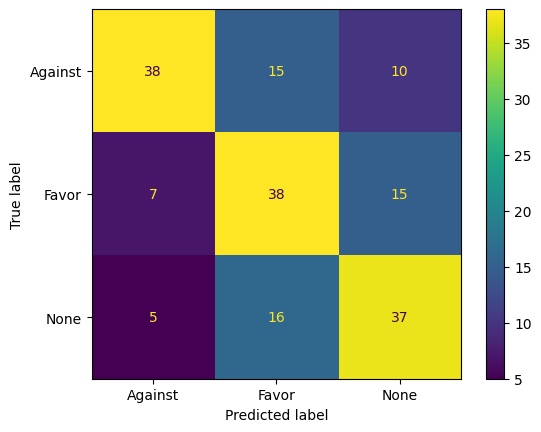

              precision    recall  f1-score   support

     Against       0.76      0.60      0.67        63
       Favor       0.55      0.63      0.59        60
        None       0.60      0.64      0.62        58

    accuracy                           0.62       181
   macro avg       0.64      0.62      0.63       181
weighted avg       0.64      0.62      0.63       181



In [ ]:
target_names = ['Against', 'Favor', 'None']

confusion_matrix = metrics.confusion_matrix(testlabels, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=target_names)
cm_display.plot()
plt.show()


print(classification_report(testlabels, predictions,target_names=target_names))

## **Classification after augmentation**

In [ ]:
label_list, texts = to_list(final)

1    219
0    219
2    218
dtype: int64


In [ ]:
max_len = 0

for sent in texts:

    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  41


In [ ]:
input_ids = []
attention_masks = []

for text in texts:
    encoded_dict = tokenizer.encode_plus(
                        text,
                        add_special_tokens = True,
                        max_length = max_len,
                        truncation = True,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )


    input_ids.append(encoded_dict['input_ids'])

    attention_masks.append(encoded_dict['attention_mask'])


input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(label_list)


print('Original: ', texts[0])
print('Token IDs:', input_ids[0])


/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  we remind ourselv love mean be will give until hurt mother teresa
Token IDs: tensor([  101,  2057, 10825, 14635,  2884,  2615,  2293,  2812,  2022,  2097,
         2507,  2127,  3480,  2388, 12409,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0])


In [ ]:

dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.8 * len(dataset))
#val_size = int(0.2 * len(dataset))
val_size = len(dataset)  - train_size


train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  524 training samples
  132 validation samples


In [ ]:
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 3,
    output_attentions = False,
    output_hidden_states = False,
)


model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
total_steps

330

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []
t_acc=[]
t_loss=[]
v_acc=[]
v_loss=[]


total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):


    #               Training

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')


    t0 = time.time()
    total_train_loss = 0
    total_train_accuracy = 0
    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        output = model(b_input_ids,
                             token_type_ids=None,
                             attention_mask=b_input_mask,
                             labels=b_labels)

        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()


        total_train_accuracy += flat_accuracy(logits, label_ids)
        # ------------------------------------------------------------

        loss = output.loss
        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()


    avg_train_accuracy = total_train_accuracy / len(train_dataloader)
    print("  Train Accuracy: {0:.2f}".format(avg_train_accuracy))

    avg_train_loss = total_train_loss / len(train_dataloader)


    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))


    print("")
    print("Running Validation...")
    t0 = time.time()

    model.eval()
    # Tracking variables
    total_eval_accuracy = 0
    best_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0


    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():
            output= model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = output.loss
        total_eval_loss += loss.item()

        logits = output.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)


    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)
    if avg_val_accuracy > best_eval_accuracy:
        torch.save(model, 'bert_model1')
        best_eval_accuracy = avg_val_accuracy
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))


    # ----------------------------------------------------------
    t_acc.append(avg_train_accuracy)
    t_loss.append(avg_train_loss)
    v_acc.append(avg_val_accuracy)
    v_loss.append(avg_val_loss)
    #----------------------------------------------------------

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Accur': avg_train_accuracy,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )
print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...
  Train Accuracy: 0.31

  Average training loss: 1.19
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.36
  Validation Loss: 1.17

======== Epoch 2 / 10 ========
Training...
  Train Accuracy: 0.32

  Average training loss: 1.18
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.36
  Validation Loss: 1.17

======== Epoch 3 / 10 ========
Training...
  Train Accuracy: 0.32

  Average training loss: 1.18
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.36
  Validation Loss: 1.17

======== Epoch 4 / 10 ========
Training...
  Train Accuracy: 0.32

  Average training loss: 1.18
  Training epcoh took: 0:00:04

Running Validation...
  Accuracy: 0.36
  Validation Loss: 1.17

======== Epoch 5 / 10 ========
Training...
  Train Accuracy: 0.33

  Average training loss: 1.18
  Training epcoh took: 0:00:05

Running Validation...
  Accuracy: 0.36
  Validation Loss: 1.17

======== Epoch 6 / 10 ========
Tra

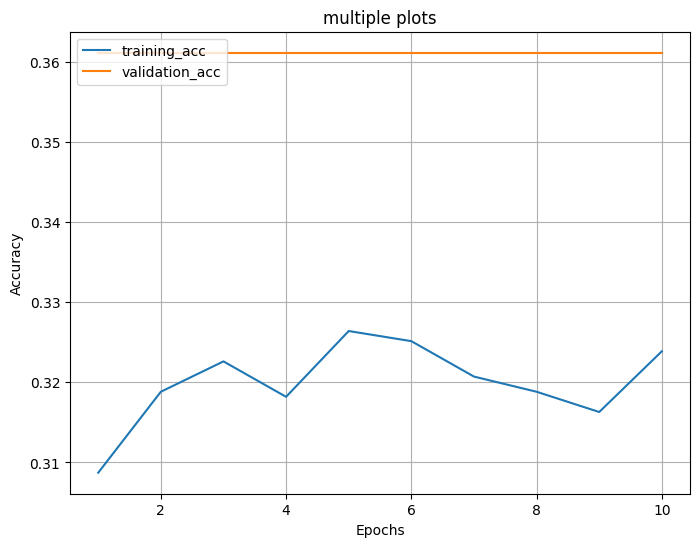

In [ ]:

x = np.array([1, 2, 3, 4,5,6,7,8,9,10])
y = t_acc
y2 = v_acc

fig, ax = plt.subplots(figsize=(8,6))

plt.plot(x, y, label='training_acc')
plt.plot(x, y2, label='validation_acc')
plt.legend(loc="upper left")
plt.grid()

# for index in range(len(x)):
#   ax.text(x[index], y[index], y[index], size=12)

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('multiple plots')
plt.show()

Testing the performance

In [ ]:
testlabels, testtexts = to_list(testdata)

0    63
1    60
2    58
dtype: int64


In [ ]:
test_input_ids = []
test_attention_masks = []
for tweet in testtexts:
    encoded_dict = tokenizer.encode_plus(
                        tweet,
                        add_special_tokens = True,
                        max_length = max_len,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt',
                   )
    test_input_ids.append(encoded_dict['input_ids'])
    test_attention_masks.append(encoded_dict['attention_mask'])

test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
test_dataset = TensorDataset(test_input_ids, test_attention_masks)
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
predictions = []
my_predictions=[]
for batch in test_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        # b_labels = batch[2].to(device)
        with torch.no_grad():
            output= model(b_input_ids,
                                   token_type_ids=None,
                                   attention_mask=b_input_mask)
            logits = output.logits
            logits = logits.detach().cpu().numpy()
            pred_flat = np.argmax(logits, axis=1).flatten()

            predictions.extend(list(pred_flat))

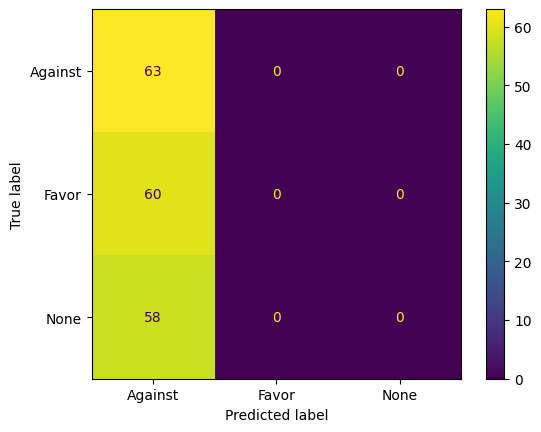

              precision    recall  f1-score   support

     Against       0.35      1.00      0.52        63
       Favor       0.00      0.00      0.00        60
        None       0.00      0.00      0.00        58

    accuracy                           0.35       181
   macro avg       0.12      0.33      0.17       181
weighted avg       0.12      0.35      0.18       181



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
target_names = ['Against', 'Favor', 'None']

confusion_matrix = metrics.confusion_matrix(testlabels, predictions)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=target_names)
cm_display.plot()
plt.show()


print(classification_report(testlabels, predictions,target_names=target_names))